In [43]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits import mplot3d
from PIL import Image, ImageDraw, ImageFont
from queue import PriorityQueue

class GameMap:
    ''' GameMap holds basic map information and provides a helper function.'''
    
    dirs = [(1, 0), (0, 1), (-1, 0), (0, -1)] # Cardinal directions

    def __init__(self, width, height):
        self.width = width
        self.height = height

    def get_neighbors(self, coords):
        '''Gets neighbor cells in cardinal directions. Coords is (x, y).'''
        
        res = []
        for dir in self.dirs:
            neighbor = (coords[0] + dir[0], coords[1] + dir[1])

            # Only add cells within the map boundary
            if 0 <= neighbor[0] < self.width and 0 <= neighbor[1] < self.height:
                res.append(neighbor)
        return res

class Path:
    '''Path is a container for a vector of adjoining cells leading from a
    starting coordinate to an ending coordinate. Coords are (x, y).'''
    
    def __init__(self, coords_list):
        self.coords_list = coords_list

    def __str__(self):
        return f'start: {self.coords_list[0]}, end: {self.coords_list[-1]}'

class Room:
    ''' Room holds the center coordinate of a room and the extents of
    its dimensions, where the dimension length is twice the extent plus
    one.'''
    
    def __init__(self, x, y, width_extent, height_extent):
        self.x = x
        self.y = y
        self.width_extent = width_extent
        self.height_extent = height_extent

    def __str__(self):
        return f'x: {self.x}, y: {self.y}, WE: {self.width_extent}, HE: {self.height_extent}'

    def get_coords(self):
        return (self.x, self.y)

class DungeonGenerator:
    '''Contains the main logic for generating the dungeon. Target room count
    informs the number of rooms generated; however, they may overlap. Map width
    and height determine the size of the squre map in cells. Min and max room
    dimensions inform how large the rooms are.'''

    # Initialize lists of rooms and paths
    rooms = []
    paths = []

    def __init__(self, target_room_count=12, map_width=48, map_height=32, min_room_dim=5, max_room_dim=15):
        # Set parameters, minimum 1
        self.target_room_count = target_room_count if target_room_count > 0 else 1
        self.map_width = map_width if map_width > 0 else 1
        self.map_height = map_height if map_height > 0 else 1
        self.min_room_dim = min_room_dim if min_room_dim > 0 else 1
        self.max_room_dim = max_room_dim if max_room_dim > 0 else 1

        # Initialize random number generator
        self.rng = np.random.default_rng()

        # Initialize game map
        self.game_map = GameMap(map_width, map_height)
        
        # Initialize cost map
        self.cost_map = np.ones((self.game_map.height, self.game_map.width))

    def select_room_coords(self, costs):
        '''Chooses coordinates for a new room. This is based on the cost map
        of the dungeon. Cells with higher costs are less likely to be chosen.'''
    
        # Get cost sums along each axis
        x_costs = costs.sum(axis=0)
        y_costs = costs.sum(axis=1)
    
        # Probability for selection is inverse of cost
        x_inv_costs = (x_costs.max() + 1) - x_costs # All values above zero
        y_inv_costs = (y_costs.max() + 1) - y_costs # All values above zero
        x = self.rng.choice(range(x_costs.shape[0]), p=x_inv_costs / x_inv_costs.sum())
        y = self.rng.choice(range(y_costs.shape[0]), p=y_inv_costs / y_inv_costs.sum())
        return x, y
    
    def ldist(self, c1, c2, w):
        '''Converts Euclidean distance to a weighted, diminishing logistic output.'''
        dist = np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2)
        return w**2 / (1 + np.exp(dist))
    
    def manhattan_dist(self, c1, c2):
        '''Manhattan distance between two coordinates.'''
        return abs(c1[0] - c2[0]) + abs(c1[1] - c2[1])
    
    def find_path(self, start_coords, end_coords, game_map, costs):
        '''Based on the implementation by Red Blob Games. Uses an A* pathfinding
        algorithm to chart a path between two cells. The game_map's cost map is
        used as movement costs.'''
    
        # Initialize a priority queue of explorable cells primed with start coords
        frontier = PriorityQueue(maxsize=game_map.width * game_map.height)
        frontier.put((0, start_coords))
    
        # Initialize breadcrumb dictionary
        came_from = dict()
        came_from[start_coords] = None
    
        # Initialize cost dictionary
        cost_so_far = dict()
        cost_so_far[start_coords] = 0
    
        # Search
        while not frontier.empty():
            # Get the next lowest cost search option
            current = frontier.get()[1]
    
            # Stop early if end coords reached
            if current == end_coords:
                break
    
            # Search neighboring cells
            for next in game_map.get_neighbors(current):
                # Use the cost map to get the movement cost
                new_cost = cost_so_far[current] + self.cost_map[next[1], next[0]]
    
                # Save this cost for this move if it's the lowest we have
                if next not in cost_so_far or new_cost < cost_so_far[next]:
                    cost_so_far[next] = new_cost
                    priority = new_cost + self.manhattan_dist(end_coords, next) # Cost + heuristic
                    frontier.put((priority, next))
                    came_from[next] = current
    
        # To make the path, follow breadcrumbs backward from end to start
        current = end_coords
        path = []
        while current != start_coords:
            path.append(current)
            current = came_from[current]
        path.append(start_coords)
        return path

    def generate(self, room_cost_weight=3, path_cost_weight=1):
        '''Generate a new map. If desired, pass room_cost_weight and path_cost_weight,
        which may both accept floats, and will affect the random placement of room
        centers and the paths between them.'''

        # Put target_room_count room centers on the map
        self.rooms = []
        for _ in range(self.target_room_count):
            # Choose room center coordinates
            rx, ry = self.select_room_coords(self.cost_map)
            min_extent = int(self.min_room_dim / 2)
            max_extent = int(self.max_room_dim / 2)
            rand_width_extent = self.rng.choice(range(min_extent, max_extent))
            rand_height_extent = self.rng.choice(range(min_extent, max_extent))
            self.rooms.append(Room(rx, ry, rand_width_extent, rand_height_extent))
        
            # Apply diminishing logistic costs around room center
            for idxs, _ in np.ndenumerate(self.cost_map):
                self.cost_map[idxs] += self.ldist(idxs, (ry, rx), room_cost_weight)
        
        # Connect each room in one giant loop
        node_pairs = [(i, i + 1) for i in range(self.target_room_count)]
        node_pairs[-1] = (node_pairs[-1][0], node_pairs[0][0])
        self.paths = []
        for node_pair in node_pairs:
          # Create path
          coords_a = self.rooms[node_pair[0]].get_coords()
          coords_b = self.rooms[node_pair[1]].get_coords()
          path = Path(self.find_path(coords_a, coords_b, self.game_map, self.cost_map))
          self.paths.append(path)
        
          # Update weights
          for coords in path.coords_list:
            for cost_coords, _ in np.ndenumerate(self.cost_map):
              self.cost_map[cost_coords] += self.ldist(cost_coords, (coords[1], coords[0]), path_cost_weight)
        
        # Return the generator
        return self
    
    def save_image(self, image_path='dungeon.jpg', cell_size=16):
        '''Save an image of the map to disk. Pass cell_size an integer greater
        than zero to change the pixel size of cells.'''

        # Initialize image
        image_size = (self.map_width * cell_size, self.map_height * cell_size)
        image = Image.new('RGB', image_size, color='black')
        draw = ImageDraw.Draw(image)

        # Draw cells
        for row in range(self.map_height):
            for col in range(self.map_width):
                x = col * cell_size
                y = row * cell_size
                draw.rectangle([x, y, x + cell_size, y + cell_size], outline='black')
        
        # Draw paths
        for path in self.paths:
            for coords in path.coords_list:
                x = coords[0] * cell_size
                y = coords[1] * cell_size
                draw.rectangle([x, y, x + cell_size, y + cell_size], fill='white',  outline='black')

        # Draw rooms
        for room in self.rooms:
            for wi in range(room.x - room.width_extent, room.x + room.width_extent + 1):
                for hi in range(room.y - room.height_extent, room.y + room.height_extent + 1):
                    x = wi * cell_size
                    y = hi * cell_size
                    draw.rectangle([x, y, x + cell_size, y + cell_size], fill='white',  outline='black')

        # Save image
        image.save(image_path)

        # Return image
        return image

    def save_cost_plot(self, img_path='cost_plot.jpg'):
        '''Visualize the cost plot in 3D.'''
        x = range(self.cost_map.shape[0])
        y = range(self.cost_map.shape[1])
        x, y = np.meshgrid(x, y)
        z = self.cost_map.T
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot_surface(x, y, z, cmap='viridis', edgecolor='green')
        ax.set_title('Final cost map')
        fig.savefig(img_path)
        return plt

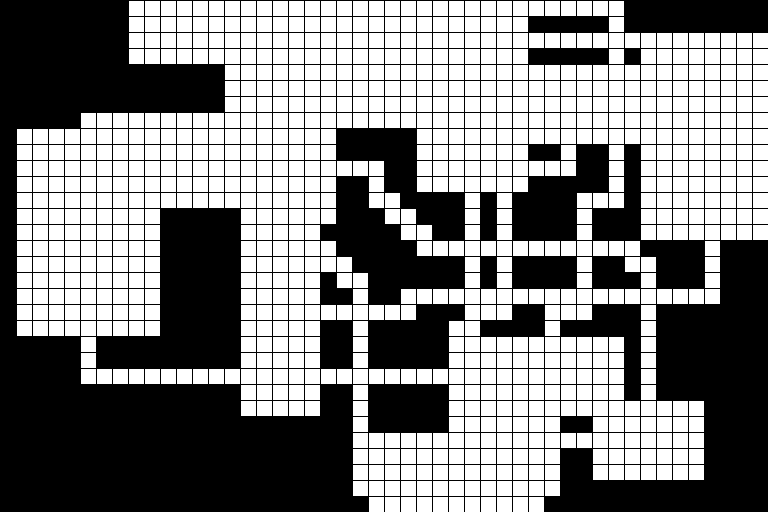

In [44]:
# Main program
dg = DungeonGenerator().generate()

# Save image
dg.save_image()

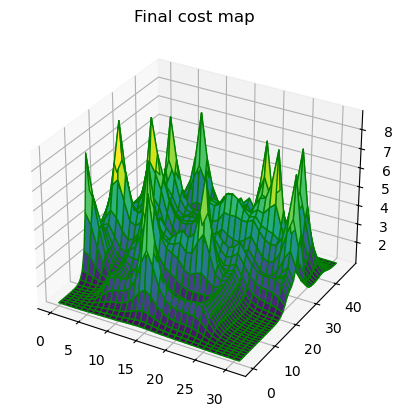

In [45]:
# Plot costs
dg.save_cost_plot().show()